### Neural Machine Translation with Transformers

In [1]:
import pandas as pd
df = pd.read_csv('Data/en-fr.txt', sep='\t', names=['en', 'fr', 'attr'], usecols=['en', 'fr'])
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


The dataset needs to be cleaned before it’s used to train a model. we need to remove numbers and punctuation symbols, convert words with Uni‐
code characters such as où into their ASCII equivalents (ou), convert characters to lowercase, and insert [start] and [end] tokens at the beginning and end of each French phrase

In [2]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


Next, we scan the dataset and determine the maximum length of the English phrases and of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model

In [3]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase lenght (English): {en_max_len}')
print(f'Max phrase lenght (English): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase lenght (English): 7
Max phrase lenght (English): 16
Sequence length: 16


Now fit one Tokenizer to the English phrases and another Tokenizer to their French equivalents, and generate padded sequences from all the phrases. Note the filters parameter passed to the French tokenizer. It configures the tokenizer to remove all the punctuation characters it normally removes except for the square brackets used to
delimit [start] and [end] tokens

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

Now we compute the vocabulary size for each language from the Tokenizer instances, These values will be used to size the model’s two embedding layers. The latter will also be used to size the output layer.

In [5]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English):  {en_vocab_size}')
print(f'Vocabulary size (French):  {fr_vocab_size}')

Vocabulary size (English):  6033
Vocabulary size (French):  12197


Finally we create the features and labels the mode will be trained with.

In [6]:
inputs = {'encoder_input': en_x, 'decoder_input': fr_y[:, :-1]}
outputs = fr_y[:, 1:]

Now let’s define a model. This time, we’ll use Keras’s functional API rather than its
sequential API. It’s necessary because this model has two inputs: one that accepts a
tokenized English phrase and another that accepts a tokenized French phrase. We’ll
also seed the random-number generators used by Keras and TensorFlow to get
repeatable results

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, TokenAndPositionEmbedding

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)

encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=False)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=100)

2025-12-25 23:35:29.269082: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-25 23:35:29.269292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-25 23:35:29.269300: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
I0000 00:00:1766705729.269847 23476785 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1766705729.270456 23476785 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)  │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ token_and_position_embeddi… │ (None, None, 256)       │      1,548,544 │ encoder_input[0][0]     │
│ (TokenAndPositionEmbedding) │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ decoder_input (InputLayer)  │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ transformer_encoder         │ (None, None, 256)       │        395,776 │ token_and_position_emb… │
│ (TransformerEncoder)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ functional (Functional)     │ (None, None, 12197)     │      6,920,613 │ decoder_input[0][0],    │
│                             │                         │                │ transformer_encoder[0]… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 8,864,933 (33.82 MB)

 Trainable params: 8,864,933 (33.82 MB)

 Non-trainable params: 0 (0.00 B)

Now call fit to train the model, and use an EarlyStopping callback to end training if
the validation accuracy fails to improve for three consecutive epochs

In [8]:


from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=2, validation_split=0.2, callbacks=[callback])

Epoch 1/2


2025-12-25 23:35:31.497522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 181s 138ms/step - accuracy: 0.7969 - loss: 1.3907 - val_accuracy: 0.8325 - val_loss: 1.0374
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 163s 130ms/step - accuracy: 0.8423 - loss: 0.9366 - val_accuracy: 0.8544 - val_loss: 0.8619


[]

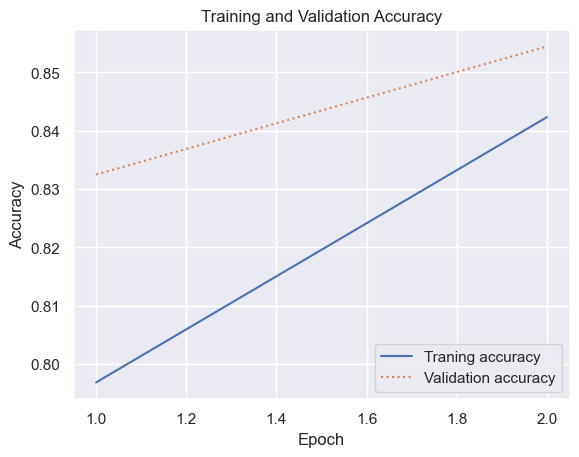

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, '-', label='Traning accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [12]:
# test the model with a sample sentence

def translate_text(text, model, en_tokenizer, fr_tokenizer, sequence_len, fr_index_lookup):
    input_sequence = en_tokenizer.texts_to_sequences([clean_text(text)])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'
    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]
        prediction = model.predict([padded_input_sequence, padded_target_sequence])
        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token
        
        if token == '[end]':
            break
    return decoded_text[8: -6]  # remove [start] and [end] tokens

fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
texts = en[40000:40010].values
for text in texts:
    translation = translate_text(text, model, en_tokenizer, fr_tokenizer, sequence_len, fr_index_lookup)
    print(f'Input: {text}')
    print(f'Translation: {translation}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Input: its fall now
Translation: cest pour maintenant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input: im losing
Translation: je suis en train de faire

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Input: it was quite funny
Translation: cetait tout

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Input: thats not unusual
Translation: ce nest pas a moi

1/1 ━━━━━━━━━━━━━━

In [15]:
translate_text('Hello world', model, en_tokenizer, fr_tokenizer, sequence_len,
 fr_index_lookup)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


'le cafe est'